In [ ]:
# downgrade tensorflow and kears version
!pip install tensorflow-gpu==1.15
!pip install keras==2.2.4

     |████████████████████████████████| 411.5MB 35kB/s 
     |████████████████████████████████| 3.8MB 50.1MB/s 
     |████████████████████████████████| 512kB 49.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b65aa20a8fc5040278ffb757ce27d55e5c3cfd723534fd534c9c0815ed82df5c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [ ]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## extracting data from zip file and loading into runtime location

In [ ]:
base_path = '/content/runtime_data/'

def extract_dataset(path):
  #Extracting the dataset from the zip file

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(base_path)
  zip_ref.close()

  

In [ ]:
extract_dataset('/content/drive/My Drive/train_data') # extracting train data

In [ ]:
extract_dataset('/content/drive/My Drive/test_data') # extracting test data 

In [ ]:
load_data = pd.read_csv("/content/drive/My Drive/demographic.csv") #extracting demographic dataset if applicable

## Model building

### Routing, squashing and masking layers

In [ ]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):

    #Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss

    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

### Capsnet + CNN layer

In [ ]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Conv 1: Just a conventional Conv2D layer
    blk1_conv_64 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv_64')(x)
    blk1_conv_2_64 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv_2_64')(blk1_conv_64)
    max_pool_1_64 = layers.MaxPool2D(pool_size=(2,2),strides=(2,2),name='max_pool_64')(blk1_conv_2_64)

    # Conv 2: Just a conventional Conv2D layer
    bkl2_conv_128 =layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='conv_128')(max_pool_1_64)
    bkl2_conv_2_128 =layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='conv_2_128')(bkl2_conv_128)
    max_pool_2_128 = layers.MaxPool2D(pool_size=(2,2),strides=(2,2), name='max_pool_128')(bkl2_conv_2_128)
    bkl3_conv_256 =layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', name='conv_256')(max_pool_2_128)
    
    conv2_caps = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv2')(bkl3_conv_256)#(max_pool_3_256)

    # Primry caps layer: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv2_caps, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Digit caps layer: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Output length caps layer: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_caps = Length(name='caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.


    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='softmax')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])


# margin loss for data classification
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


### Passing input to the model

In [ ]:
def train_model(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('out.csv')
    es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'caps': 'accuracy'})

    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    model.fit_generator(generator=train_generator(x_train, y_train, 32, 0.1),
                        steps_per_epoch=int(y_train.shape[0] / 32),
                        epochs=200,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#

    model.save_weights('out_RAM.h5')
    print('Trained model saved to \'out_RAM.h5\'')

    return model

### Model summary

In [ ]:
model = CapsNet(input_shape=[512, 512, 3],
                n_class=6,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='out.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

### Model run

In [ ]:
train_model(model=model, data=((x_train, y_train), (x_test, y_test)))

In [ ]:
log = pd.read_csv("/content/out.csv")

## Model accuracy and loss plot (for reference)

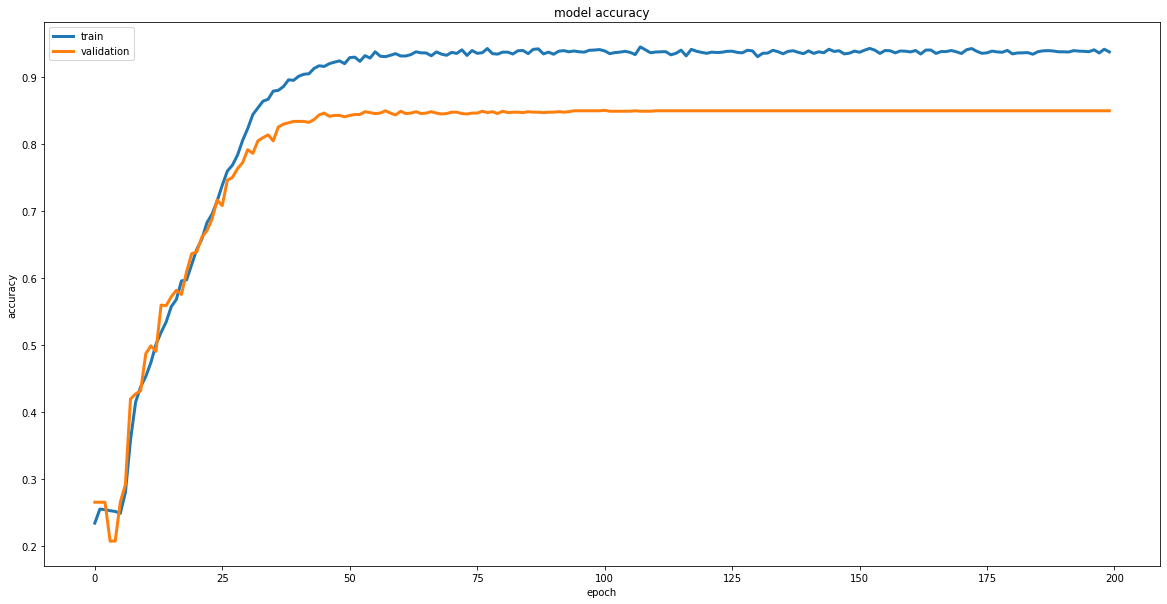

In [ ]:
#Plotting training vs validation accuracy graph

plt.figure(figsize=(20,10))
plt.plot(log['caps_acc'],linewidth=3.0)
plt.plot(log['val_caps_acc'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

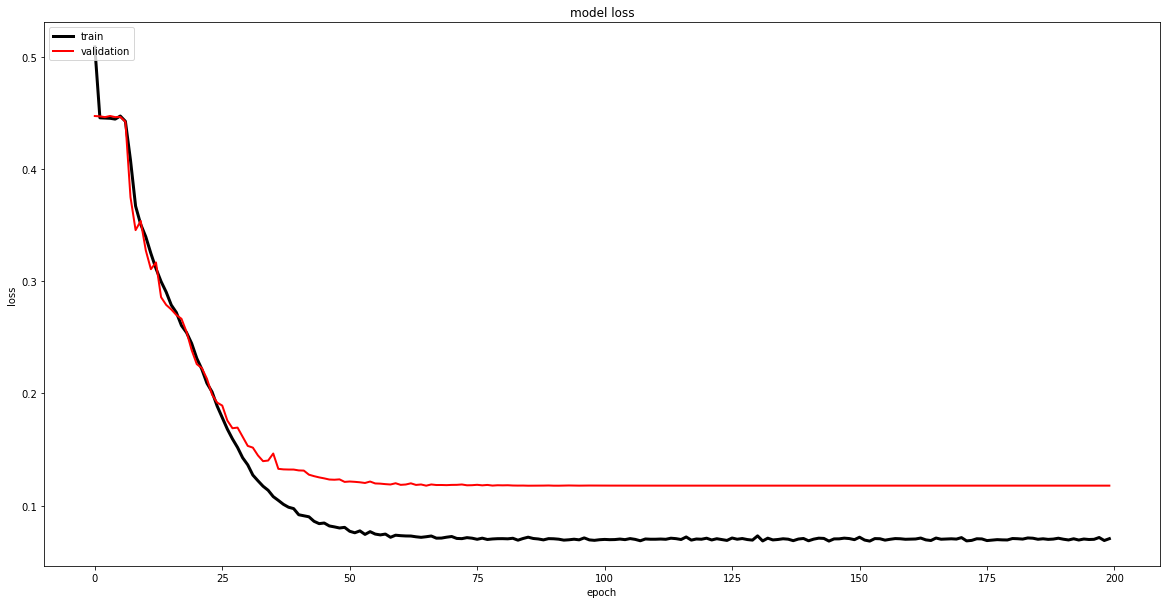

In [ ]:
#Plotting training vs validation loss graph

plt.figure(figsize=(20,10))
plt.plot(log['caps_loss'], color='black',linewidth=3.0)
plt.plot(log['val_caps_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Data preparation for ConvCaps network

### test train split

In [ ]:
"""
 #def load_OASIS():
    # the data, shuffled and split between train and test sets
import numpy as np
from sklearn.model_selection import train_test_split
    
x = img_new
y = Dataset_oasis_train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

"""

In [ ]:
x_train = img_train
x_test = img_test
y_train = Dataset_train
y_test = Dataset_test 

## Testing model accuarcy

In [ ]:
test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

### Loading pretrained weights for testing purpose

In [ ]:
from keras.models import load_model

model.load_weights('/content/out_RAM.h5')

In [ ]:
#Calculating test accuracy
test(model=model, data=(x_test, y_test))